# Building a Mosaic with Montage (one-shot)

This page runs the end-to-end mosaicking process without any explanation.  See <a href="Mosaic.ipynb">here</a> for the full descriptive Notebook.

Startup folder:      /Users/jcg/MontageDocs
Work directory:      Messier017
mHdr:                {'status': '0', 'count': 16}
mArchiveDownload:    {'status': '0', 'count': 49}
mImgtbl (raw):       {'status': '0', 'count': 49, 'badfits': 0, 'badwcs': 0}
mProjExec:           {'status': '0', 'count': 49, 'failed': 0, 'nooverlap': 0}
mImgtbl (projected): {'status': '0', 'count': 49, 'failed': 0, 'nooverlap': 0}
mOverlaps:           {'status': '0', 'count': 128}
mDiffFitExec:        {'status': '0', 'count': 128, 'diff_failed': 0, 'fit_failed': 0, 'warning': 0}
mBgModel:            {'status': '0'}
mBgExec:             {'status': '0', 'count': 49, 'nocorrection': 0, 'failed': 0}
mImgtbl (corrected): {'status': '0', 'count': 49, 'badfits': 0, 'badwcs': 0}
mAdd:                {'status': '0', 'time': 1.0}
mViewer:             {'status': '0', 'type': b'grayscale', 'nx': 3601, 'ny': 3600, 'grayminval': 149.5791825248529, 'grayminpercent': 0.0, 'grayminsigma': -2.0, 'graymaxval': 10639.0999189825,

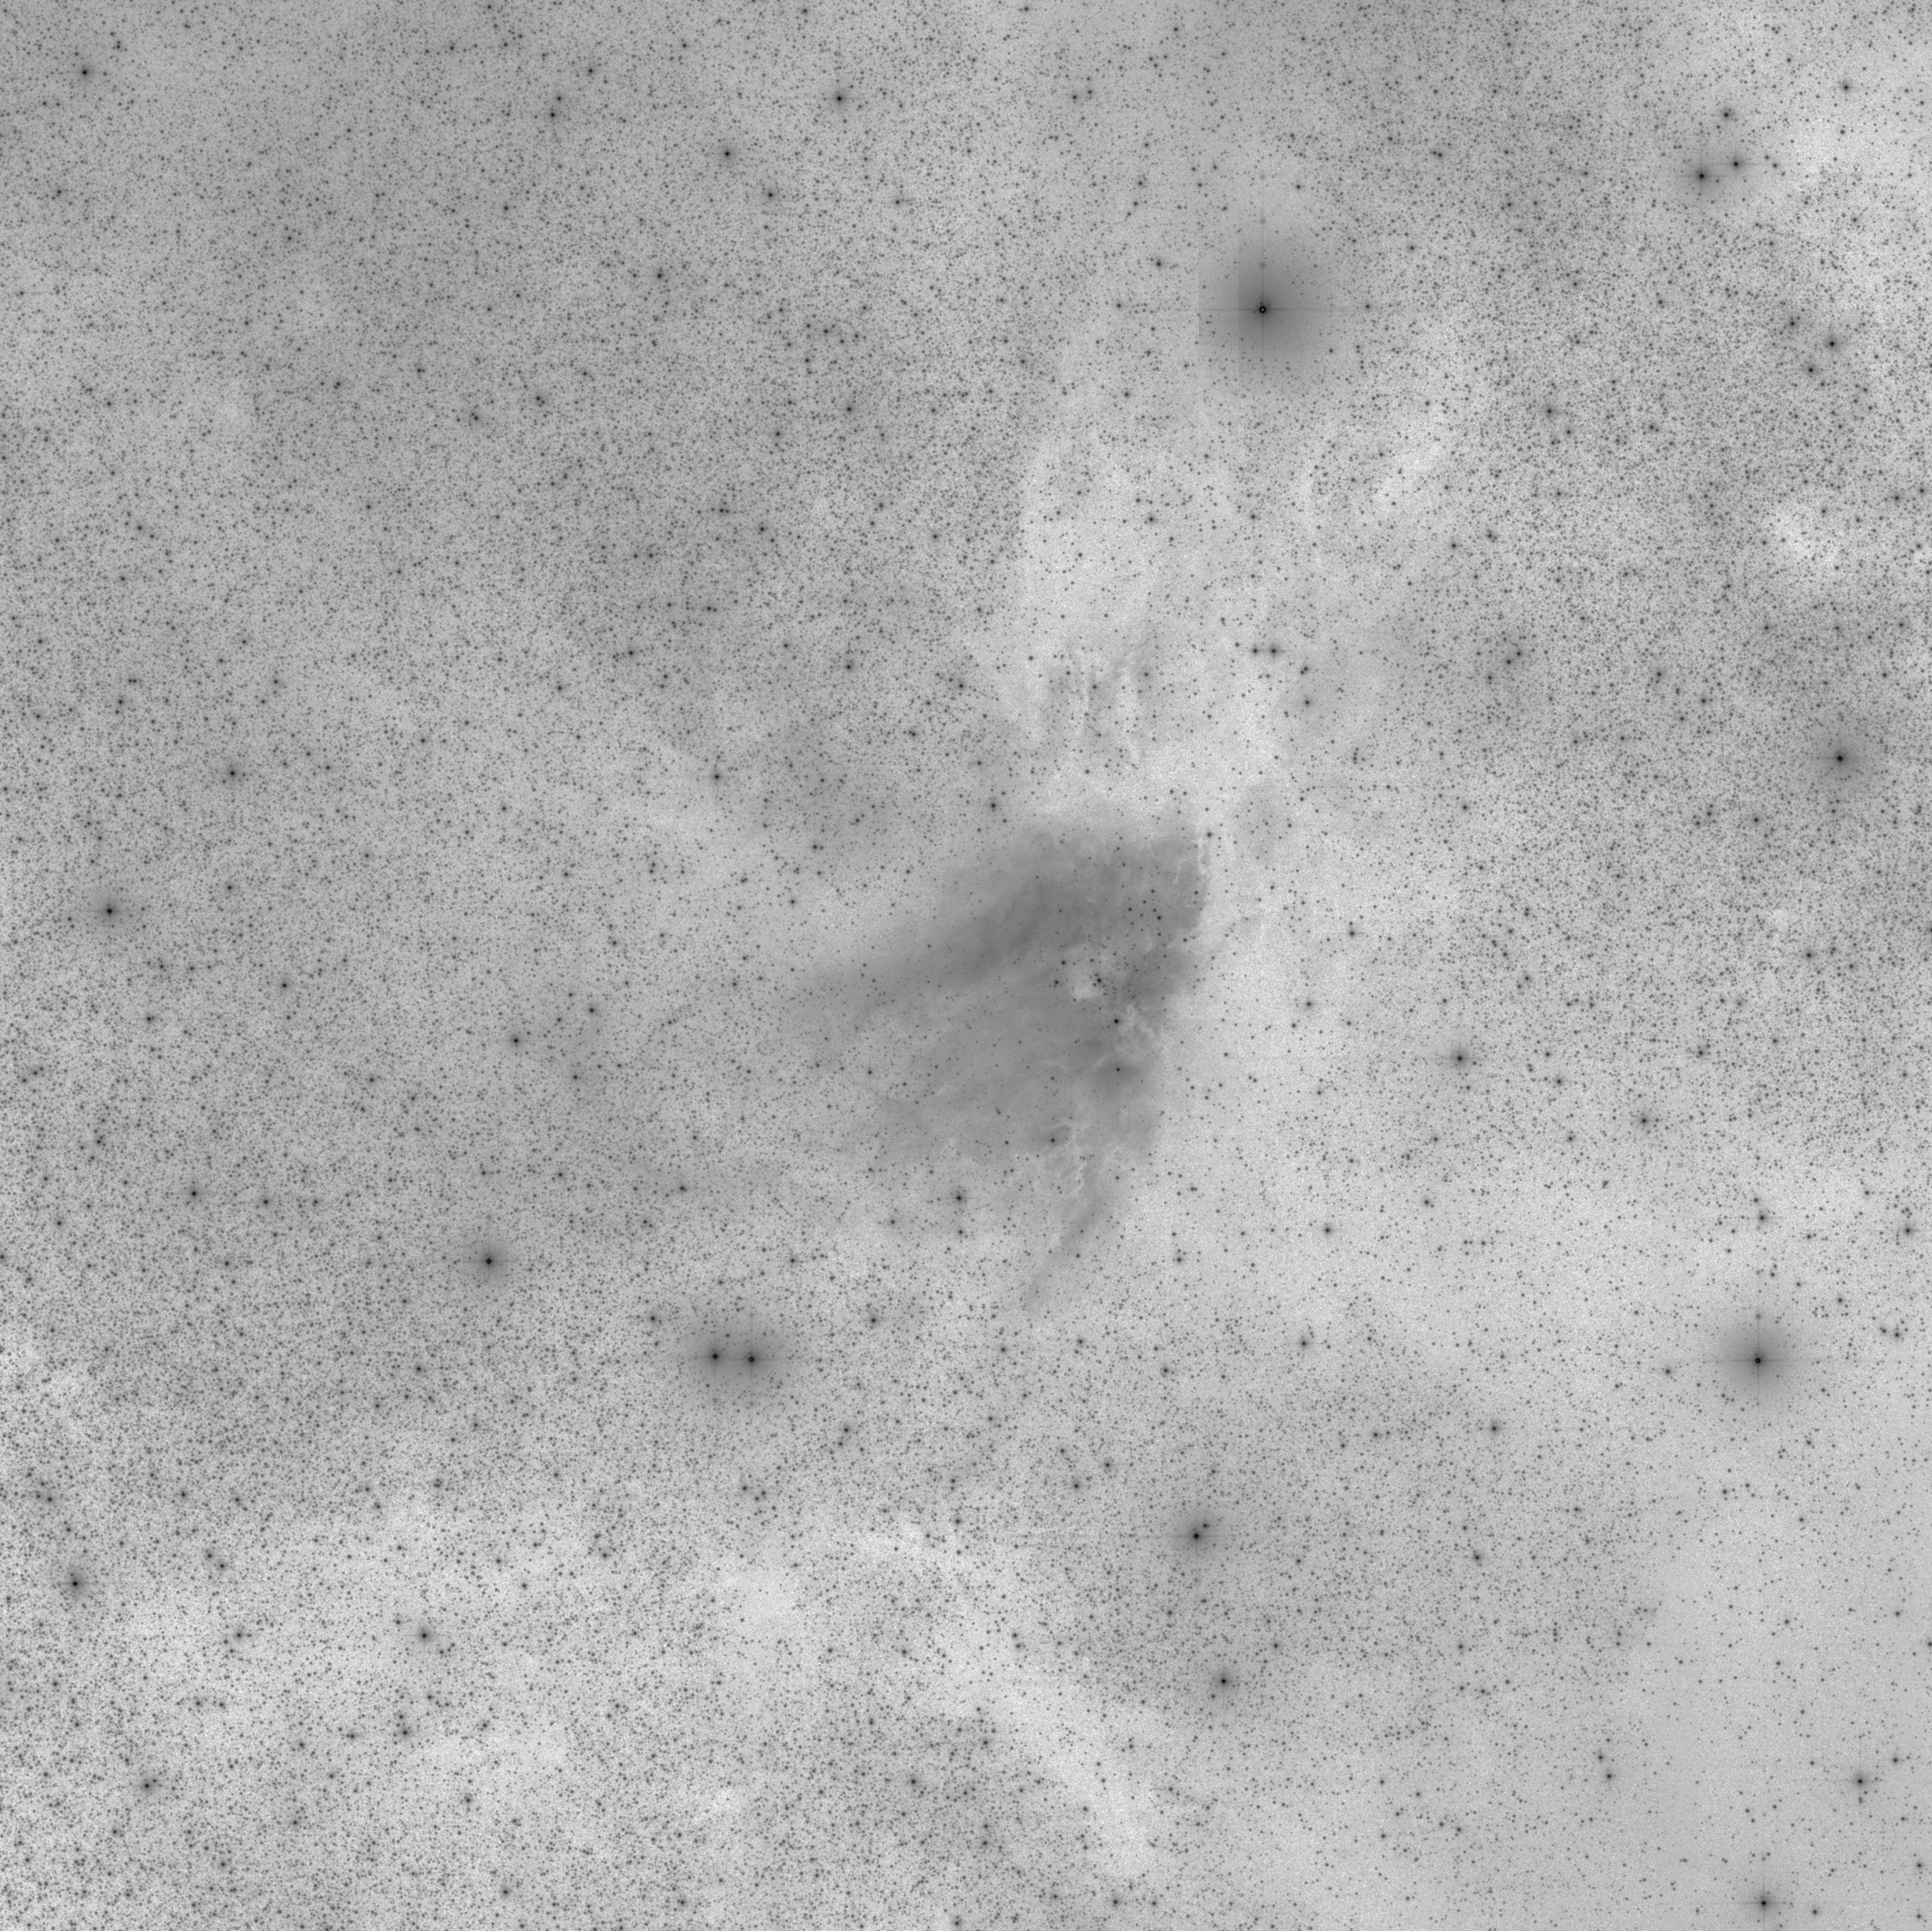

In [2]:
# Startup.  Then Montage modules are pretty much self-contained
# but this script needs a few extra utilities.

import os
import sys
import shutil

from MontagePy.main    import *
from MontagePy.archive import *

from IPython.display import Image


# These are the parameters defining the mosaic we want to make.

location  = "M 17"
size      = 1.0
dataset   = "2MASS J"
workdir   = "Messier017"


# We create and move into subdirectories in this notebook 
# but we want to come back to the original startup directory 
# whenever we restart the processing. 

try:
    home
except:
    home = os.getcwd()

os.chdir(home)

print("Startup folder:      " + home)


# Clean out any old copy of the work tree, then remake it
# and the set of the subdirectories we will need.

try:
    shutil.rmtree(workdir)
except:
    print("                     Can't delete work tree; probably doesn't exist yet")

print("Work directory:      " + workdir)

os.makedirs(workdir)  

os.chdir(workdir)

os.makedirs("raw")
os.makedirs("projected")
os.makedirs("diffs")
os.makedirs("corrected")


# Create the FITS header for the mosaic.

rtn = mHdr(location, size, size, "region.hdr")

print("mHdr:                " + str(rtn))


# Retrieve archive images covering the region then scan 
# the images for their coverage metadata.

rtn = mArchiveDownload(dataset, location, size, "raw")

print("mArchiveDownload:    " + str(rtn))

rtn = mImgtbl("raw", "rimages.tbl")

print("mImgtbl (raw):       " + str(rtn))


# Reproject the original images to the  frame of the 
# output FITS header we created

rtn = mProjExec("raw", "rimages.tbl", "region.hdr", projdir="projected", quickMode=True)

print("mProjExec:           " + str(rtn))

mImgtbl("projected", "pimages.tbl")

print("mImgtbl (projected): " + str(rtn))


# Determine the overlaps between images (for background modeling).

rtn = mOverlaps("pimages.tbl", "diffs.tbl")

print("mOverlaps:           " + str(rtn))


# Generate difference images and fit them.

rtn = mDiffFitExec("projected", "diffs.tbl", "region.hdr", "diffs", "fits.tbl")

print("mDiffFitExec:        " + str(rtn))


# Model the background corrections.

rtn = mBgModel("pimages.tbl", "fits.tbl", "corrections.tbl")

print("mBgModel:            " + str(rtn))


# Background correct the projected images.

rtn = mBgExec("projected", "pimages.tbl", "corrections.tbl", "corrected")

print("mBgExec:             " + str(rtn))

rtn = mImgtbl("corrected", "cimages.tbl")

print("mImgtbl (corrected): " + str(rtn))


# Coadd the background-corrected, projected images.

rtn = mAdd("corrected", "cimages.tbl", "region.hdr", "mosaic.fits")

print("mAdd:                " + str(rtn))


# Make a PNG rendering of the data and display it.

rtn = mViewer("-ct 1 -gray mosaic.fits -2s max gaussian-log -out mosaic.png", "", mode=2)

print("mViewer:             " + str(rtn))

Image(filename='mosaic.png')